In [1]:
# Create a PySpark session
import requests
import json
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("PySpark Weather Project") \
    .master("local[*]") \
    .getOrCreate()

# Optional: Format output tables (like DataFrames) for better display
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

# Verify Spark session
print(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/15 11:44:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


**E**TL: EXTRACT

API Data Extract Phase

- Retrieved daily weather summary data from OpenWeatherMap API
- Utilized requests library to send GET request to API endpoint
- Specified parameters: latitude, longitude, date, timezone offset, and API key
- Received JSON response containing weather data for specified location and date
- Parsed JSON response and loaded data into PySpark dataframe for further processing

In [2]:
# .env File: A file in your project directory where you store sensitive environment variables like API keys.
from dotenv import load_dotenv
import os

# Load the environment variables from the .env file
load_dotenv()

# Get the API key from the environment
api_key = os.getenv("OPENWEATHER_API_KEY")

# Define the API URL
api_url = f'https://api.openweathermap.org/data/2.5/forecast?lat=7.42&lon=3.93&appid={api_key}&units=metric'

In [3]:
# Send the API request
response = requests.get(api_url)
data = response.json()

In [4]:
data

{'cod': '200',
 'message': 0,
 'cnt': 40,
 'list': [{'dt': 1726401600,
   'main': {'temp': 27.82,
    'feels_like': 30.2,
    'temp_min': 26.66,
    'temp_max': 27.82,
    'pressure': 1013,
    'sea_level': 1013,
    'grnd_level': 985,
    'humidity': 69,
    'temp_kf': 1.16},
   'weather': [{'id': 500,
     'main': 'Rain',
     'description': 'light rain',
     'icon': '10d'}],
   'clouds': {'all': 75},
   'wind': {'speed': 2, 'deg': 171, 'gust': 2.44},
   'visibility': 10000,
   'pop': 0.89,
   'rain': {'3h': 1.95},
   'sys': {'pod': 'd'},
   'dt_txt': '2024-09-15 12:00:00'},
  {'dt': 1726412400,
   'main': {'temp': 26.69,
    'feels_like': 28.84,
    'temp_min': 24.44,
    'temp_max': 26.69,
    'pressure': 1013,
    'sea_level': 1013,
    'grnd_level': 984,
    'humidity': 77,
    'temp_kf': 2.25},
   'weather': [{'id': 501,
     'main': 'Rain',
     'description': 'moderate rain',
     'icon': '10d'}],
   'clouds': {'all': 83},
   'wind': {'speed': 2.02, 'deg': 160, 'gust': 4.07},

**About the Data**

5 day / 3 hour forecast data

The 5 day forecast is available at any location on the globe. It includes weather forecast data with 3-hour step. Forecast is available in JSON or XML format.

The data appears to represent weather forecasts for a city (likely Ibadan in this case), with various fields such as timestamp (dt), main weather attributes (main), weather conditions (weather), and more.

The key parts of the data include:

*   dt: Unix timestamp representing the time of the weather forecast.
*   main: A struct that contains temperature,pressure, humidity, etc.
*   weather: An array (possibly multiple weather conditions) with details like weather type and description.
*   clouds, wind, visibility, pop, rain, sys: Weather-related parameters (cloudiness, wind speed/direction, visibility, precipitation probability, rain volume, etc.).
*   city data: Metadata about the city, including city ID, name, coordinates (lat, lon), country, population, and timezone.

[Reference](https://openweathermap.org/forecast5#data)


Transformation Plan:

1.   Extract meaningful columns from nested fields (e.g., extract temp, humidity, wind_speed, etc.).
2.   Convert timestamp (dt) into a human-readable format.
3. Clean up any missing or NULL values for visualizations.
4. Ensure a flat DataFrame that has all required fields for visualizing trends, such as temperature, wind speed, and weather conditions over time.




Problem Encountered:

1. Some fields (like wind.speed, main.pressure, main.temp, etc.) might have integer values in some records and floating-point values in others, leading to the PySpark schema mismatch.

Solution:
Dynamic Type Casting Using PySpark Functions

You can dynamically cast your data types using the pyspark.sql.functions module during the DataFrame transformation. Cast fields to DoubleType regardless of whether they are integers or floats. PySpark will handle this automatically.

2. City Data is at a Different Level in the API Response: The city field might not be part of each individual record in the list but might exist at the root level of the API response.

The city data is outside of the list object, which means it’s not repeated for each row of weather data.

If city is part of the root response, but you’re creating a DataFrame from data['list'], then the city information will not be part of the rows in the list DataFrame unless you explicitly join it.

Solution: 
Broadcast city Information to Each Row

*   Create a DataFrame for list (weather data).
*   Create a seperate DataFrame for city
*   Use crossJoin to attach city information to every row in the list DataFrame.



In [5]:
# pyspark.sql.functions module to parse the JSON data and create a PySpark DataFrame
from pyspark.sql.functions import from_json, col

# import all the necessary classes to define the schema of your DataFrame.
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType, ArrayType

In [6]:
# The convert_int_to_float_except_dt function checks if the field is dt and avoids converting it to a float. 
# All other integer fields are still converted to floats.
def convert_int_to_float_except_dt(d):
    if isinstance(d, dict):
        return {k: convert_int_to_float_except_dt(v) if k != 'dt' else v for k, v in d.items()}
    elif isinstance(d, list):
        return [convert_int_to_float_except_dt(i) for i in d]
    elif isinstance(d, int):
        return float(d)
    return d

In [7]:
# Apply the conversion
data['list'] = convert_int_to_float_except_dt(data['list'])

In [8]:
# Step 2: Define schemas for both 'list' (weather data) and 'city'
weather_schema = StructType([  # Define the schema for weather data
    StructField("dt", LongType(), True),  # Timestamp
    StructField("main", StructType([
        StructField("temp", DoubleType(), True),
        StructField("feels_like", DoubleType(), True),
        StructField("temp_min", DoubleType(), True),
        StructField("temp_max", DoubleType(), True),
        StructField("pressure", DoubleType(), True),
        StructField("sea_level", DoubleType(), True),
        StructField("grnd_level", DoubleType(), True),
        StructField("humidity", DoubleType(), True),
        StructField("temp_kf", DoubleType(), True)
    ]), True),
    StructField("weather", ArrayType(StructType([
        StructField("id", DoubleType(), True),
        StructField("main", StringType(), True),
        StructField("description", StringType(), True),
        StructField("icon", StringType(), True)
    ])), True),
    StructField("clouds", StructType([
        StructField("all", DoubleType(), True)
    ]), True),
    StructField("wind", StructType([
        StructField("speed", DoubleType(), True),
        StructField("deg", DoubleType(), True),
        StructField("gust", DoubleType(), True)
    ]), True),
    StructField("visibility", DoubleType(), True),
    StructField("pop", DoubleType(), True),
    StructField("rain", StructType([
        StructField("3h", DoubleType(), True)
    ]), True),
    StructField("sys", StructType([
        StructField("pod", StringType(), True)
    ]), True),
    StructField("dt_txt", StringType(), True)
])

city_schema = StructType([  # Define the schema for city data
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("coord", StructType([
        StructField("lat", DoubleType(), True),
        StructField("lon", DoubleType(), True)
    ]), True),
    StructField("country", StringType(), True),
    StructField("population", LongType(), True),
    StructField("timezone", LongType(), True),
    StructField("sunrise", LongType(), True),
    StructField("sunset", LongType(), True)
])

In [9]:
# Step 4: Create DataFrames for 'list' and 'city'
weather_df = spark.createDataFrame(data['list'], schema=weather_schema)

city_data = [data['city']]  # Convert city dictionary into a list for DataFrame creation
city_df = spark.createDataFrame([data['city']], schema=city_schema)

In [10]:
weather_df.printSchema()

root
 |-- dt: long (nullable = true)
 |-- main: struct (nullable = true)
 |    |-- temp: double (nullable = true)
 |    |-- feels_like: double (nullable = true)
 |    |-- temp_min: double (nullable = true)
 |    |-- temp_max: double (nullable = true)
 |    |-- pressure: double (nullable = true)
 |    |-- sea_level: double (nullable = true)
 |    |-- grnd_level: double (nullable = true)
 |    |-- humidity: double (nullable = true)
 |    |-- temp_kf: double (nullable = true)
 |-- weather: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: double (nullable = true)
 |    |    |-- main: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- icon: string (nullable = true)
 |-- clouds: struct (nullable = true)
 |    |-- all: double (nullable = true)
 |-- wind: struct (nullable = true)
 |    |-- speed: double (nullable = true)
 |    |-- deg: double (nullable = true)
 |    |-- gust: double (nullable = true)
 |-- visib

In [11]:
weather_df.show(truncate=False)

+----------+---------------------------------------------------------------+---------------------------------------+-------+-------------------+----------+----+------+---+-------------------+
|dt        |main                                                           |weather                                |clouds |wind               |visibility|pop |rain  |sys|dt_txt             |
+----------+---------------------------------------------------------------+---------------------------------------+-------+-------------------+----------+----+------+---+-------------------+
|1726401600|{27.82, 30.2, 26.66, 27.82, 1013.0, 1013.0, 985.0, 69.0, 1.16} |[{500.0, Rain, light rain, 10d}]       |{75.0} |{2.0, 171.0, 2.44} |10000.0   |0.89|{1.95}|{d}|2024-09-15 12:00:00|
|1726412400|{26.69, 28.84, 24.44, 26.69, 1013.0, 1013.0, 984.0, 77.0, 2.25}|[{501.0, Rain, moderate rain, 10d}]    |{83.0} |{2.02, 160.0, 4.07}|10000.0   |1.0 |{4.22}|{d}|2024-09-15 15:00:00|
|1726423200|{24.61, 25.42, 23.01, 24.61,

In [12]:
city_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- coord: struct (nullable = true)
 |    |-- lat: double (nullable = true)
 |    |-- lon: double (nullable = true)
 |-- country: string (nullable = true)
 |-- population: long (nullable = true)
 |-- timezone: long (nullable = true)
 |-- sunrise: long (nullable = true)
 |-- sunset: long (nullable = true)



In [13]:
city_df.show(truncate=False)

+-------+------+------------+-------+----------+--------+----------+----------+
|id     |name  |coord       |country|population|timezone|sunrise   |sunset    |
+-------+------+------------+-------+----------+--------+----------+----------+
|2339354|Ibadan|{7.42, 3.93}|NG     |3565108   |3600    |1726378480|1726422261|
+-------+------+------------+-------+----------+--------+----------+----------+



In [14]:
# Broadcast the 'city' information to all weather rows using a cross join
combined_df = weather_df.crossJoin(city_df)

In [15]:
# Step 6: Show data to confirm city information is present in each row
combined_df.show(truncate=False)

+----------+---------------------------------------------------------------+---------------------------------------+-------+-------------------+----------+----+------+---+-------------------+-------+------+------------+-------+----------+--------+----------+----------+
|dt        |main                                                           |weather                                |clouds |wind               |visibility|pop |rain  |sys|dt_txt             |id     |name  |coord       |country|population|timezone|sunrise   |sunset    |
+----------+---------------------------------------------------------------+---------------------------------------+-------+-------------------+----------+----+------+---+-------------------+-------+------+------------+-------+----------+--------+----------+----------+
|1726401600|{27.82, 30.2, 26.66, 27.82, 1013.0, 1013.0, 985.0, 69.0, 1.16} |[{500.0, Rain, light rain, 10d}]       |{75.0} |{2.0, 171.0, 2.44} |10000.0   |0.89|{1.95}|{d}|2024-09-15 12:00:00

**Goal**:

•	Flat and Clean Structure: The data should be in a flat format (without nested structures) with clear, human-readable columns.

•	Suitable for Analytics: The dataset should be ready for SQL-based analytics, loading into databases (e.g., Apache Hive, MySQL, etc.), and efficient querying.

•	Ready for Visualization: Each column should represent a metric or dimension that can be easily visualized (e.g., temperature trends, weather conditions, etc.).

**Ideal Data Structure**

Each row should represent a weather forecast record for a particular city at a specific time. Here’s an ideal structure for this purpose:
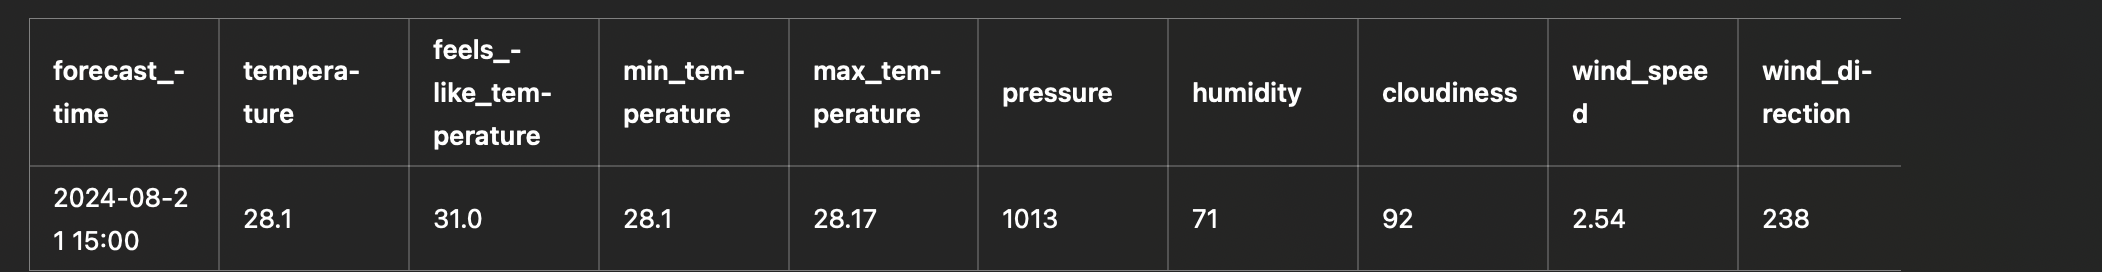



**Steps to Achieve This**:
1.	Flatten the Data: Extract relevant fields from the nested JSON and make sure all columns are flat and in human-readable form.
2.	Format the Data: Ensure proper formatting of time columns and handle missing values (fill or drop NULLs).
3.	Save the Data: Store the data in a CSV or Parquet format for easy loading into databases and visualization.


In [16]:
# 1. Here’s how we can flatten and extract the necessary columns based on this schema:

#	•	Weather data: Nested fields inside main, weather, clouds, wind, etc.
#	•	City data: Fields like name, coord, country, and others are already present at the root level, so they can be accessed directly.

from pyspark.sql import functions as F

# Flatten the necessary columns
df_flat = combined_df.select(
    F.from_unixtime(F.col("dt")).alias("forecast_time"),  # Convert Unix timestamp to human-readable format
    F.col("main.temp").alias("temperature"),
    F.col("main.feels_like").alias("feels_like_temperature"),
    F.col("main.temp_min").alias("min_temperature"),
    F.col("main.temp_max").alias("max_temperature"),
    F.col("main.pressure").alias("pressure"),
    F.col("main.humidity").alias("humidity"),
    
    F.col("clouds.all").alias("cloudiness"),
    F.col("wind.speed").alias("wind_speed"),
    F.col("wind.deg").alias("wind_direction"),
    F.col("visibility"),
    F.col("pop").alias("precipitation_probability"),
    F.col("rain.3h").alias("rain_volume"),  # Rain volume (can be NULL)
    
    # Accessing the first element of the weather array
    F.col("weather").getItem(0).getField("main").alias("weather_main"),
    F.col("weather").getItem(0).getField("description").alias("weather_description"),
    
    # Access city-related columns from the root level
    F.col("name").alias("city_name"),
    F.col("country").alias("country"),
    F.col("coord.lat").alias("city_latitude"),
    F.col("coord.lon").alias("city_longitude"),
    F.col("population").alias("population"),
    F.col("timezone").alias("timezone"),
    F.col("sunrise").alias("sunrise"),
    F.col("sunset").alias("sunset")
)

# Show the flat DataFrame to confirm the structure
df_flat.show(truncate=False)

+-------------------+-----------+----------------------+---------------+---------------+--------+--------+----------+----------+--------------+----------+-------------------------+-----------+------------+-------------------+---------+-------+-------------+--------------+----------+--------+----------+----------+
|forecast_time      |temperature|feels_like_temperature|min_temperature|max_temperature|pressure|humidity|cloudiness|wind_speed|wind_direction|visibility|precipitation_probability|rain_volume|weather_main|weather_description|city_name|country|city_latitude|city_longitude|population|timezone|sunrise   |sunset    |
+-------------------+-----------+----------------------+---------------+---------------+--------+--------+----------+----------+--------------+----------+-------------------------+-----------+------------+-------------------+---------+-------+-------------+--------------+----------+--------+----------+----------+
|2024-09-15 13:00:00|27.82      |30.2                  

In [17]:
# 2. Handle Missing Values

# Fill missing values for rain_volume (set to 0 if NULL)
df_flat = df_flat.fillna({"rain_volume": 0})

In [18]:
# 3. Convert Unix timestamps in 'sunrise' and 'sunset' columns to human-readable datetime
df_flat = df_flat.withColumn("sunrise", F.from_unixtime("sunrise", "yyyy-MM-dd HH:mm:ss")) \
       .withColumn("sunset", F.from_unixtime("sunset", "yyyy-MM-dd HH:mm:ss"))

In [19]:
# 4. Convert Timezone to UTC Offset
# Convert 'timezone' from seconds to human-readable UTC offset format
df_flat = df_flat.withColumn("timezone", F.concat(
    F.lit("UTC"),
    F.when(F.col("timezone") >= 0, F.lit("+")).otherwise(F.lit("-")),
    (F.abs(F.col("timezone")) / 3600).cast("int")
))

In [20]:
# 5. Replace Country Code (NG) to Full Country Name (Nigeria)
df_flat = df_flat.withColumn("country", F.when(F.col("country") == "NG", "Nigeria").otherwise(F.col("country")))

In [21]:
df_flat.show()

+-------------------+-----------+----------------------+---------------+---------------+--------+--------+----------+----------+--------------+----------+-------------------------+-----------+------------+-------------------+---------+-------+-------------+--------------+----------+--------+-------------------+-------------------+
|      forecast_time|temperature|feels_like_temperature|min_temperature|max_temperature|pressure|humidity|cloudiness|wind_speed|wind_direction|visibility|precipitation_probability|rain_volume|weather_main|weather_description|city_name|country|city_latitude|city_longitude|population|timezone|            sunrise|             sunset|
+-------------------+-----------+----------------------+---------------+---------------+--------+--------+----------+----------+--------------+----------+-------------------------+-----------+------------+-------------------+---------+-------+-------------+--------------+----------+--------+-------------------+-------------------+
|

Save Flattened DataFrame to Google Drive or Local machine

**Troubleshoot**

The reason you’re seeing multiple CSV files inside a folder instead of a single CSV file is that PySpark partitions the data when writing to disk by default. Each partition gets saved as a separate file (e.g., part-00000...csv). PySpark does this to optimize performance for large datasets.

**Solution**: Combine the Partitioned Files into a Single CSV

To save it as a single CSV file:

1. Coalesce to a Single Partition
2. Rename the Single Output File


In [22]:
# This will create a folder named transformed_weather_data_single.csv in your directory with only one part-00000...csv file. 
# You can rename this file or use it directly.

# Save as CSV
output_path = '/Users/freDelicious/Documents/WeatherProject/transformed_weather_data_single.csv'

# Coalesce to a single partition and write as CSV
df_flat.coalesce(1).write.csv(output_path, header=True, mode="overwrite")

# Save as Parquet (if you prefer Parquet)
# output_path_parquet = '/Users/freDelicious/Documents/WeatherProject/transformed_weather_data.parquet'
# df_flat.write.parquet(output_path_parquet, mode="overwrite")

In [23]:
import os
import shutil

# Define the folder and final file name
folder_path = '/Users/freDelicious/Documents/WeatherProject/transformed_weather_data_single.csv'
final_csv = '/Users/freDelicious/Documents/WeatherProject/transformed_weather_data.csv'

# Find the part file
for filename in os.listdir(folder_path):
    if filename.startswith('part-'):
        part_file = os.path.join(folder_path, filename)
        # Move and rename the file
        shutil.move(part_file, final_csv)

# Optionally, remove the folder (since the file has been renamed)
shutil.rmtree(folder_path)

In [24]:
# If working in IDE and want to save the file in Google Drive, 
# here’s how to save the flattened DataFrame as a CSV and parquet in the My Learnings folder:


# Use PyDrive to Upload Files to Google Drive (pip install PyDrive)
# You can use the PyDrive library to authenticate and upload files to Google Drive directly from your Python script.

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import os

# Step 1: Authenticate with Google Drive
gauth = GoogleAuth()
gauth.LocalWebserverAuth()  # This will open a browser for Google authentication

# Step 2: Initialize the PyDrive client
drive = GoogleDrive(gauth)

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=446521365998-708erf4ehef5r49q7oqtst6sogdd6anh.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.


In [25]:
# Step 3: Define the local path of the file to be uploaded
local_file_path = '/Users/freDelicious/Documents/WeatherProject/transformed_weather_data.csv'

# Step 4: Create a file in Google Drive
upload_file = drive.CreateFile({'title': 'transformed_weather_data.csv'})  # File name on Google Drive

# Step 5: Set the content of the file from your local file
upload_file.SetContentFile(local_file_path)

# Step 6: Upload the file to Google Drive
upload_file.Upload()

# Confirm upload
print(f'File successfully uploaded to Google Drive: {upload_file["title"]}')

File successfully uploaded to Google Drive: transformed_weather_data.csv



# 5: Visualize Data and Create an Interactive Web App


**Goal**: 

Visualize the weather data and create a simple interactive web app using Streamlit.

**Why Seaborn and Steamlit**

Seaborn is perfect for creating attractive, informative statistical visualisations from weather data.


**Step 1: Efficient Visualizations with Seaborn**

Seaborn is perfect for creating attractive, informative statistical visualizations from your weather data. Here’s how to leverage it effectively with your weather data.

Visualization Ideas for Weather Data

1. Time Series (Temperature, Humidity, Rain):
	Track how weather parameters like temperature, humidity, and rain change over time.
2.	Distribution of Weather Conditions: Using histograms or box plots to understand the distribution of temperatures, rain volume, etc.
3.	Correlation between Variables: Scatterplots can show relationships between two variables, like humidity vs. rain volume.

**Weather-themed dashboard**


•   Temperature and Heat-related data: Warm shades, such as orange or yellow.

•	Wind and Pressure: Cool shades, like blue or teal.

•	Precipitation and Rain: Deep blues or light blues for rain-related elements.

•	Sunrise/Sunset: Soft warm tones like sunset orange or light pink.

Overall Color Palette:

1.	#1f77b4 - Cool Blue (for wind, rain, and general lines)
2.	#ff7f0e - Warm Orange (for temperature or sunlight-related data)
3.	#2ca02c - Fresh Green (for precipitation probabilities)
4.	#d62728 - Red (for maximum temperature or critical levels)
5.	#9467bd - Light Purple (for feels-like temperature)
6.	#7f7f7f - Neutral Gray (for background elements, grid lines)


In [26]:
import pandas as pd

# Load the CSV data
df = pd.read_csv('/Users/freDelicious/Documents/WeatherProject/transformed_weather_data.csv')

# Quick look at the data
print(df.head())

         forecast_time  temperature  feels_like_temperature  min_temperature  \
0  2024-09-15 13:00:00        27.82                   30.20            26.66   
1  2024-09-15 16:00:00        26.69                   28.84            24.44   
2  2024-09-15 19:00:00        24.61                   25.42            23.01   
3  2024-09-15 22:00:00        22.39                   23.24            22.39   
4  2024-09-16 01:00:00        22.08                   22.88            22.08   

   max_temperature  pressure  humidity  cloudiness  wind_speed  \
0            27.82    1013.0      69.0        75.0        2.00   
1            26.69    1013.0      77.0        83.0        2.02   
2            24.61    1013.0      88.0        92.0        1.57   
3            22.39    1015.0      98.0        99.0        1.86   
4            22.08    1013.0      97.0        99.0        2.20   

   wind_direction  ...  weather_main  weather_description  city_name  country  \
0           171.0  ...          Rain     

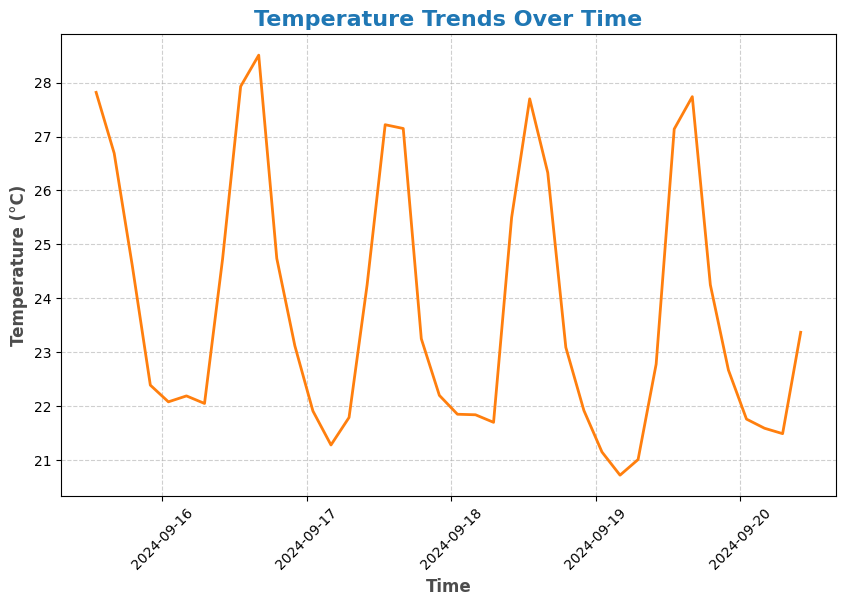

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'forecast_time' column to datetime format if it's not already
df['forecast_time'] = pd.to_datetime(df['forecast_time'])

# Plot temperature trends over time
plt.figure(figsize=(10, 6))

# Using a warm orange color for the line plot
sns.lineplot(x='forecast_time', y='temperature', data=df, color='#ff7f0e', linewidth=2)

# Adding titles and labels
plt.title('Temperature Trends Over Time', fontsize=16, fontweight='bold', color='#1f77b4')
plt.xlabel('Time', fontsize=12, fontweight='bold', color='#4c4c4c')
plt.ylabel('Temperature (°C)', fontsize=12, fontweight='bold', color='#4c4c4c')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, fontsize=10)

# Set the grid style
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

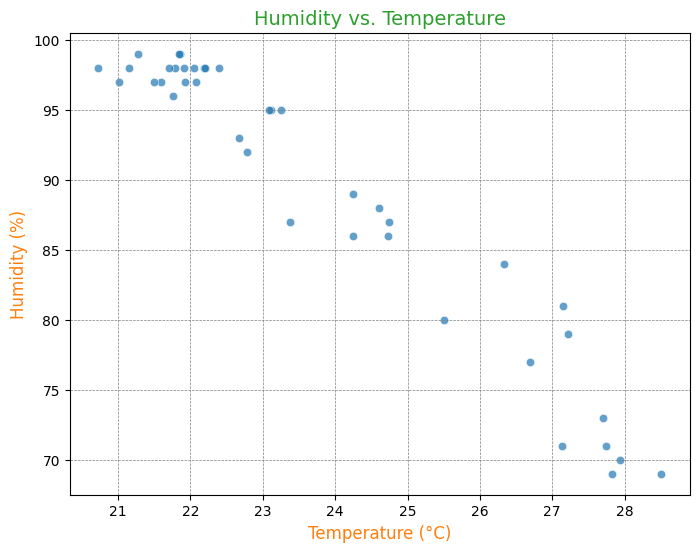

In [28]:
# Scatterplot of Humidity vs. Temperature
plt.figure(figsize=(8, 6))

# Use cool blues for the points and adjust the transparency (alpha) for a cleaner look
sns.scatterplot(x='temperature', y='humidity', data=df, color='#1f77b4', alpha=0.7)

# Customize the chart with the color theme
plt.title('Humidity vs. Temperature', fontsize=14, color='#2ca02c')  # Fresh green for title
plt.xlabel('Temperature (°C)', fontsize=12, color='#ff7f0e')  # Warm orange for labels
plt.ylabel('Humidity (%)', fontsize=12, color='#ff7f0e')

# Light grey grid for subtle aesthetics
plt.grid(True, color='#7f7f7f', linestyle='--', linewidth=0.5)

plt.show()

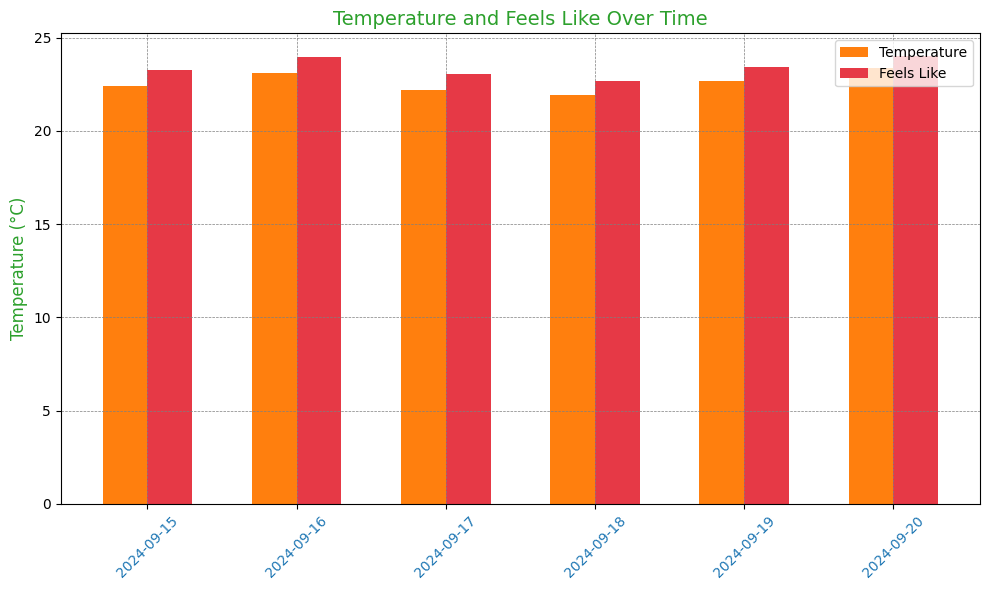

In [29]:
# Temperature and Feels Live Over Time 
import numpy as np

# Step 1: Convert 'forecast_time' to just the date part and add as a new column
df['date'] = df['forecast_time'].dt.date

# Step 2: Group by the 'date' and get the last entry for each day
df_daily = df.groupby('date').last().reset_index()

# Step 3: Set up the figure and axes for the plot
plt.figure(figsize=(10, 6))

# Define the width of the bars and positions for each bar set
width = 0.3
x = np.arange(len(df_daily['date']))

# Warm orange for Temperature and harsher red for Feels Like
plt.bar(x - width/2, df_daily['temperature'], width=width, color='#ff7f0e', label='Temperature')  # Warm orange for temperature
plt.bar(x + width/2, df_daily['feels_like_temperature'], width=width, color='#e63946', label='Feels Like')  # Harsher red for feels like

# Format the plot with cool tones for labels
plt.xticks(ticks=x, labels=df_daily['date'], rotation=45, color='#1f77b4')  # Cool blue for the x-labels
plt.title('Temperature and Feels Like Over Time', fontsize=14, color='#2ca02c')  # Fresh green for the title
plt.ylabel('Temperature (°C)', fontsize=12, color='#2ca02c')  # Green for the ylabel
plt.legend(loc='upper right')
plt.grid(True, color='#7f7f7f', linestyle='--', linewidth=0.5)  # Light grey grid
plt.tight_layout()

# Show the plot
plt.show()



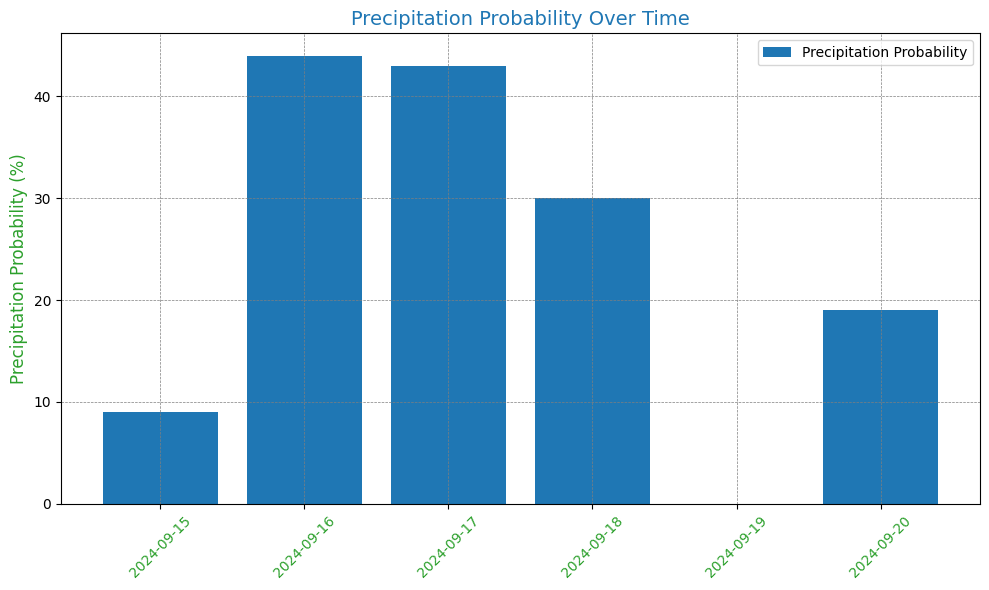

In [30]:
# Precipitation Probability Over Time
# Step 1: Convert 'forecast_time' to just the date part
df['date'] = df['forecast_time'].dt.date

# Step 2: Group by 'date' and get the last entry for each day
df_daily = df.groupby('date').last().reset_index()

# Step 3: Set up the figure and axes for Precipitation plot
plt.figure(figsize=(10, 6))

# Define the bar positions
x = np.arange(len(df_daily['date']))

# Plot Precipitation Probability as a bar plot with deeper blue
plt.bar(x, df_daily['precipitation_probability'] * 100, color='#1f77b4', label='Precipitation Probability')  # Deep blue for precipitation

# Format the plot with cool colors for labels
plt.xticks(ticks=x, labels=df_daily['date'], rotation=45, color='#2ca02c')  # Cool green for the x-ticks
plt.title('Precipitation Probability Over Time', fontsize=14, color='#1f77b4')  # Blue for the title
plt.ylabel('Precipitation Probability (%)', fontsize=12, color='#2ca02c')  # Green for the y-label
plt.legend(loc='upper right')
plt.grid(True, color='#7f7f7f', linestyle='--', linewidth=0.5)  # Light grey grid
plt.tight_layout()

# Show the plot
plt.show()

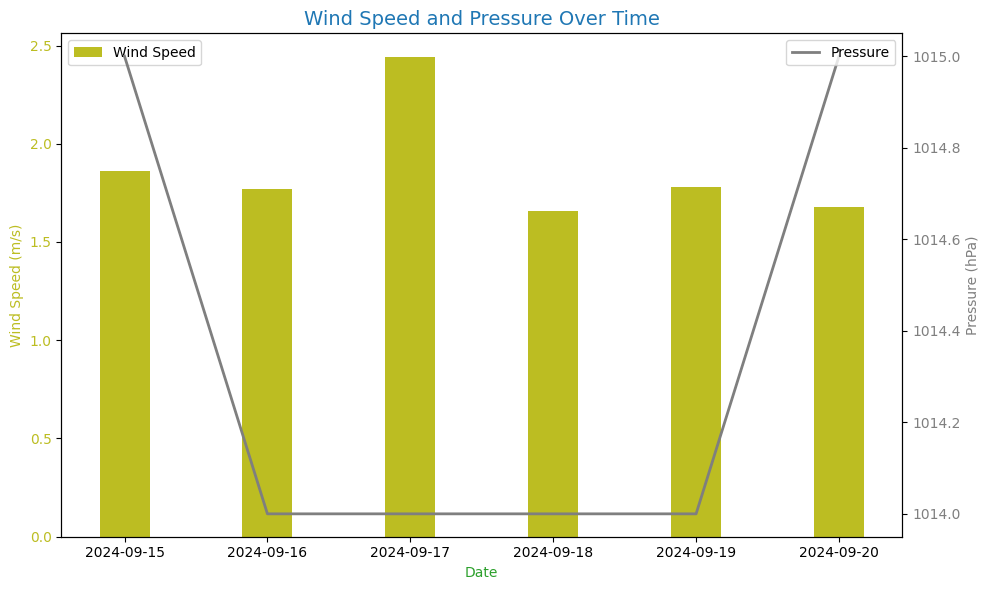

In [31]:
# Wind Speed and Pressure Over Time

# Step 1: Convert 'forecast_time' to just the date part
df['date'] = df['forecast_time'].dt.date

# Step 2: Group by 'date' and get the last entry for each day
df_daily = df.groupby('date').last().reset_index()

# Step 3: Set up the figure and axes for Wind Speed and Pressure plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Define the width of the bars and positions for each bar set
width = 0.35
x = np.arange(len(df_daily['date']))

# Plot Wind Speed on the left y-axis with an earthy brown color
ax1.bar(x, df_daily['wind_speed'], width=width, color='#bcbd22', label='Wind Speed')  # Earthy brownish color for wind
ax1.set_xlabel('Date', color='#2ca02c')
ax1.set_ylabel('Wind Speed (m/s)', color='#bcbd22')
ax1.tick_params(axis='y', labelcolor='#bcbd22')

# Create a second y-axis for Pressure, using a dark neutral color
ax2 = ax1.twinx()
ax2.plot(x, df_daily['pressure'], color='#7f7f7f', label='Pressure', linewidth=2)  # Neutral grey for pressure
ax2.set_ylabel('Pressure (hPa)', color='#7f7f7f')
ax2.tick_params(axis='y', labelcolor='#7f7f7f')

# Format the x-axis with date labels in green to match the theme
plt.xticks(ticks=x, labels=df_daily['date'], rotation=45, color='#2ca02c')

# Add titles and legends
plt.title('Wind Speed and Pressure Over Time', fontsize=14, color='#1f77b4')  # Title in blue for consistency
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot with tight layout for better spacing
plt.tight_layout()
plt.show()



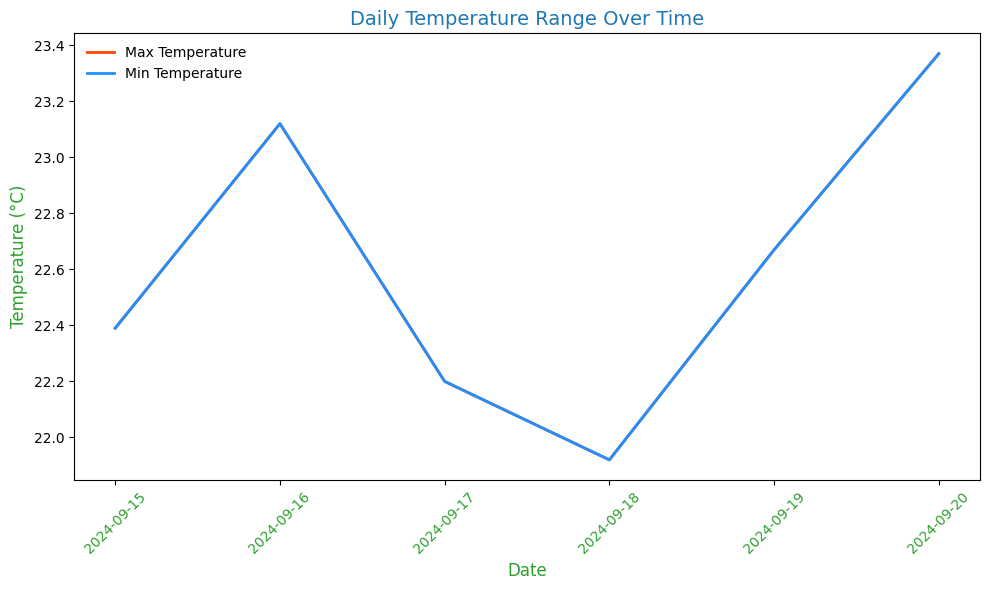

In [32]:
# 1. Temperature Range vs. Time
# Purpose: Show how the temperature varies over the course of the forecasted days, highlighting the range between the minimum and maximum temperatures for each day.
# Insights: This chart will highlight the fluctuations in temperature ranges, such as cold or hot days, making it easier to spot trends over time.
import matplotlib.dates as mdates

# Set up figure size
plt.figure(figsize=(10, 6))

# Plot the max and min temperatures using warm and cool colors
plt.plot(df_daily['date'], df_daily['max_temperature'], label='Max Temperature', color='#FF4500', linewidth=2)  # Warm red-orange
plt.plot(df_daily['date'], df_daily['min_temperature'], label='Min Temperature', color='#1E90FF', linewidth=2)  # Cool blue

# Fill the area between max and min temperatures with a neutral color
plt.fill_between(df_daily['date'], df_daily['min_temperature'], df_daily['max_temperature'], color='#d3d3d3', alpha=0.3)

# Set the title and labels with an aesthetic weather theme
plt.title('Daily Temperature Range Over Time', fontsize=14, color='#1f77b4')
plt.xlabel('Date', fontsize=12, color='#2ca02c')
plt.ylabel('Temperature (°C)', fontsize=12, color='#2ca02c')

# Format the x-axis dates for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Rotate the date labels for clarity
plt.xticks(rotation=45, color='#2ca02c')

# Add legend with a weather-friendly placement
plt.legend(loc='upper left', frameon=False)

# Adjust layout to avoid overlap and ensure the plot looks balanced
plt.tight_layout()

# Show the plot
plt.show()

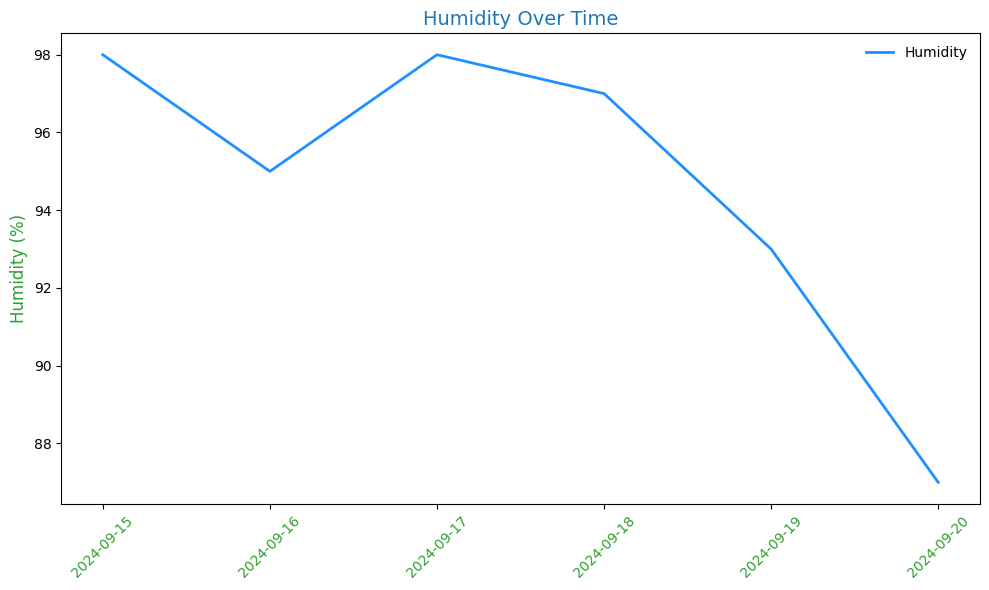

In [33]:
# 2. Humidity Over Time
# Purpose: Analyze the variation in humidity over time and see if it correlates with other variables like temperature or precipitation.
# Insights: You can spot high or low humidity days and relate them to precipitation or temperature trends. For instance, high humidity could signal impending rain.

# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot Humidity over time using a cool blue color
plt.plot(df_daily['date'], df_daily['humidity'], color='#1E90FF', label='Humidity', linewidth=2)

# Set the title and labels with weather-themed aesthetics
plt.title('Humidity Over Time', fontsize=14, color='#1f77b4')
plt.ylabel('Humidity (%)', fontsize=12, color='#2ca02c')

# Format the x-axis dates for clarity
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Rotate the date labels for better readability
plt.xticks(rotation=45, color='#2ca02c')

# Add the legend with a natural, clean placement
plt.legend(loc='upper right', frameon=False)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

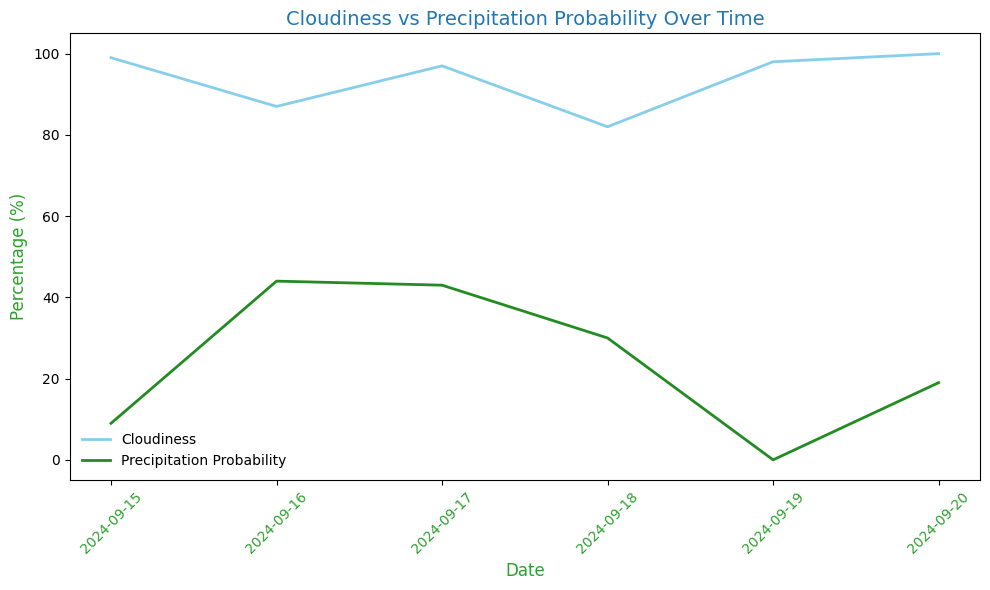

In [34]:
# 3. Cloudiness vs. Precipitation Probability
# Purpose: Understand how cloudiness correlates with the probability of precipitation (rain). High cloudiness might correlate with a higher chance of rain.
# Insights: This chart will help you see the relationship between cloudy days and the likelihood of rain. It could also show outliers where cloudiness is high, but rain is unlikely (or vice versa).

# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot Cloudiness and Precipitation Probability with weather-themed colors
plt.plot(df_daily['date'], df_daily['cloudiness'], color='#87CEEB', label='Cloudiness', linewidth=2)  # Light blue for cloudiness
plt.plot(df_daily['date'], df_daily['precipitation_probability'] * 100, color='#228B22', label='Precipitation Probability', linewidth=2)  # Green for precipitation

# Set title and labels with weather-inspired colors
plt.title('Cloudiness vs Precipitation Probability Over Time', fontsize=14, color='#1f77b4')
plt.xlabel('Date', fontsize=12, color='#2ca02c')
plt.ylabel('Percentage (%)', fontsize=12, color='#2ca02c')

# Format x-axis dates and rotate for readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45, color='#2ca02c')

# Add the legend with a natural, clean placement
plt.legend(loc='best', frameon=False)

# Adjust the layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()

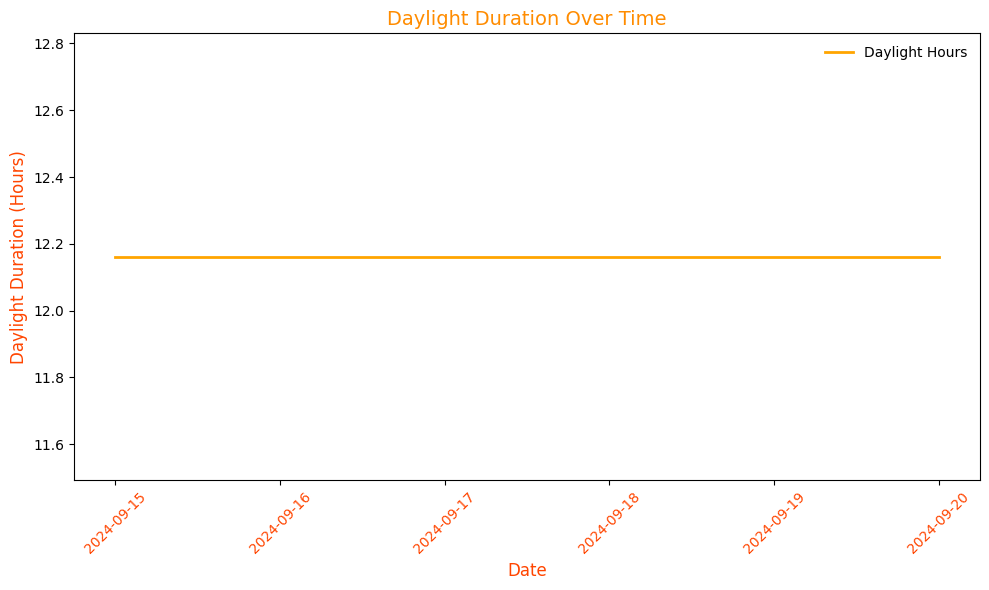

In [35]:
# 4. Sunrise and Sunset Time Analysis
# Purpose: Track how sunrise and sunset times change over the days and how long the daylight lasts.
# Insights: This could highlight seasonal changes, if applicable, in daylight duration or any changes in sunrise and sunset timings.

# Convert 'sunrise' and 'sunset' columns to datetime if not already
if pd.api.types.is_string_dtype(df_daily['sunrise']):
    df_daily['sunrise'] = pd.to_datetime(df_daily['sunrise'])
else:
    df_daily['sunrise'] = pd.to_datetime(df_daily['sunrise'], unit='s')

if pd.api.types.is_string_dtype(df_daily['sunset']):
    df_daily['sunset'] = pd.to_datetime(df_daily['sunset'])
else:
    df_daily['sunset'] = pd.to_datetime(df_daily['sunset'], unit='s')

# Calculate daylight duration in hours
df_daily['daylight_hours'] = (df_daily['sunset'] - df_daily['sunrise']).dt.total_seconds() / 3600

# Set up the figure for the plot
plt.figure(figsize=(10, 6))

# Plot Daylight Duration with a warm color scheme
plt.plot(df_daily['date'], df_daily['daylight_hours'], color='#FFA500', label='Daylight Hours', linewidth=2)  # Orange for daylight

# Set the title and labels with consistent theme colors
plt.title('Daylight Duration Over Time', fontsize=14, color='#FF8C00')  # Warm orange
plt.xlabel('Date', fontsize=12, color='#FF4500')  # Red-orange
plt.ylabel('Daylight Duration (Hours)', fontsize=12, color='#FF4500')  # Red-orange

# Format x-axis dates for better clarity
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45, color='#FF4500')  # Red-orange

# Add legend with warm colors and adjust the layout
plt.legend(loc='best', frameon=False)
plt.tight_layout()

# Show the plot
plt.show()

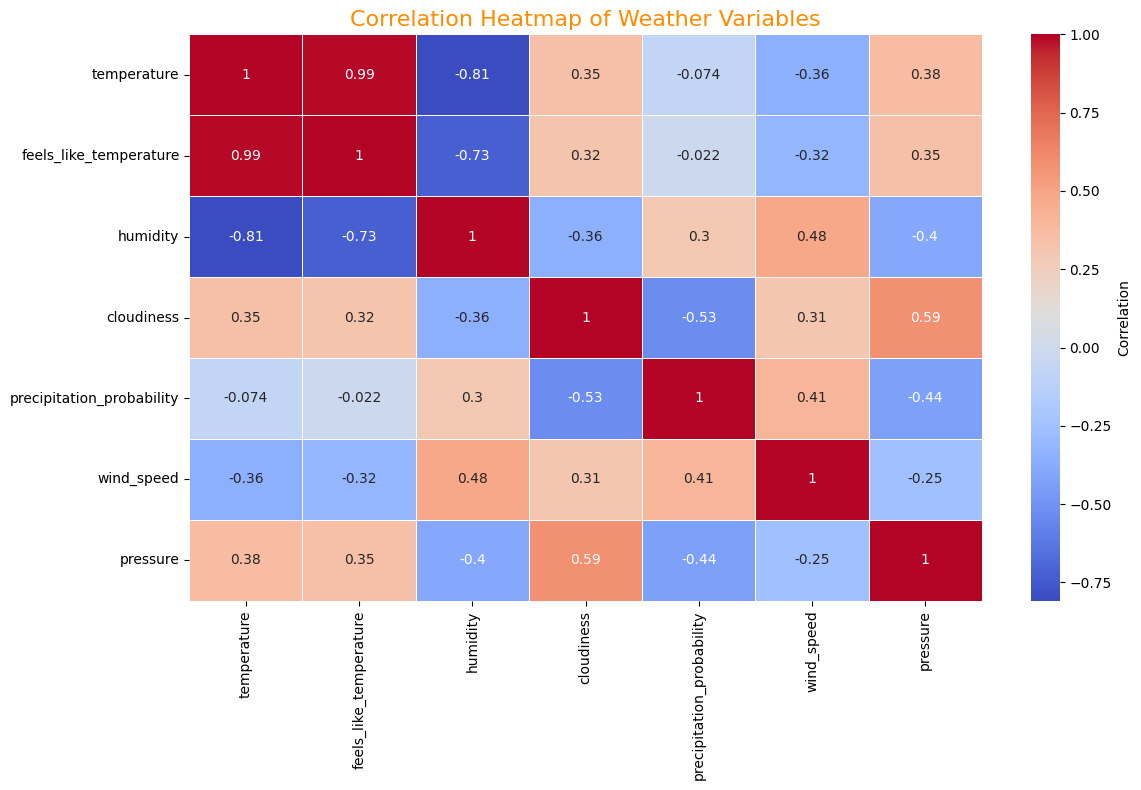

In [36]:
# 5. Heatmap of Weather Conditions
# Purpose: Create a heatmap to observe how various weather conditions such as temperature, humidity, and precipitation interact over time.
# Insights: This will help to identify correlations, such as whether higher temperatures lead to lower humidity, or how wind speed interacts with pressure and precipitation.

# Set the figure size for better readability
plt.figure(figsize=(12, 8))

# Calculate the correlation matrix for selected weather variables
corr_matrix = df_daily[['temperature', 'feels_like_temperature', 'humidity', 'cloudiness', 'precipitation_probability', 'wind_speed', 'pressure']].corr()

# Plot the heatmap using coolwarm color scheme
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10}, cbar_kws={'label': 'Correlation'})

# Set title and adjust layout
plt.title('Correlation Heatmap of Weather Variables', fontsize=16, color='#FF8C00')  # Title with warm orange
plt.tight_layout()

# Show the plot
plt.show()

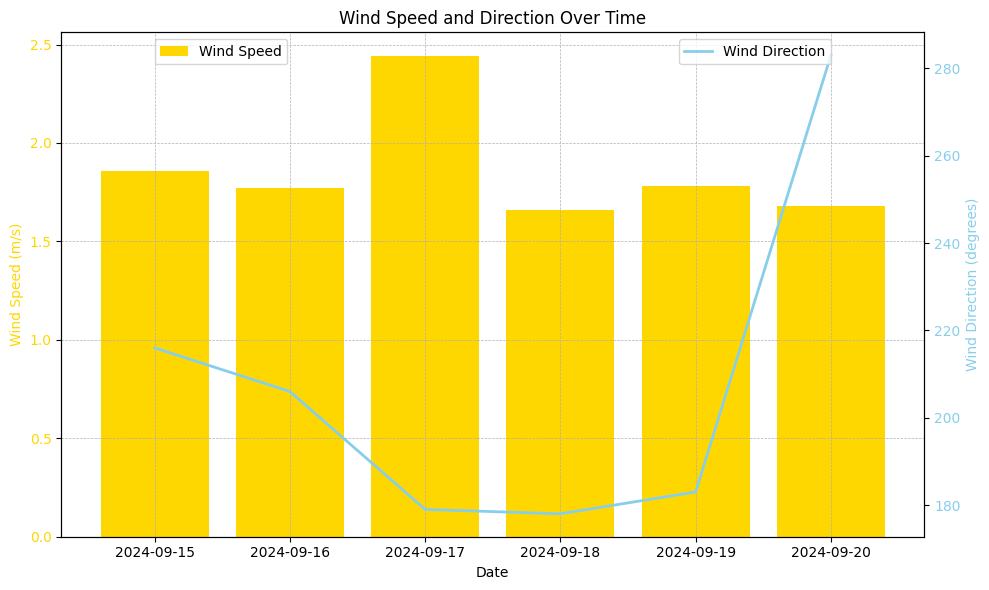

In [37]:
# 6. Wind Speed and Direction Over Time
# Purpose: Track the changes in wind speed and its direction throughout the forecast period.
# Insights: This plot can show how the wind direction changes along with speed, which may be important for weather patterns.

# Set up the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Wind Speed (Bar Plot on the first y-axis)
ax1.bar(df_daily['date'], df_daily['wind_speed'], color='gold', label='Wind Speed', width=0.8)

# Set title and labels for Wind Speed
ax1.set_xlabel('Date')
ax1.set_ylabel('Wind Speed (m/s)', color='gold')
ax1.tick_params(axis='y', labelcolor='gold')
ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Add gridlines for clarity

# Create another y-axis for Wind Direction
ax2 = ax1.twinx()
ax2.plot(df_daily['date'], df_daily['wind_direction'], color='skyblue', label='Wind Direction', linewidth=2)

# Set title and labels for Wind Direction
ax2.set_ylabel('Wind Direction (degrees)', color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Set x-axis format for date
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)

# Add legends for both y-axes
ax1.legend(loc='upper left', bbox_to_anchor=(0.1, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(0.9, 1))

# Add a title to the plot
plt.title('Wind Speed and Direction Over Time')

# Adjust layout to avoid overlap and show the plot
plt.tight_layout()
plt.show()

Step 2: Interactive Web App with Streamlit

Streamlit lets you create interactive dashboards quickly. You can display your visualizations from Seaborn and allow users to explore the data interactively.